In [55]:
import json
import logomaker
from collections import Counter
from augur.utils import json_to_tree
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import pandas as pd
import numpy as np

# Figure 3 Supplement: Egg-adaptive mutations  in NP of influenza A viruses

In [56]:
cmap = {'h3n2': {'shading':'#a986d5', 'rbd_text':'#6C3BAA'}, 
       'h1n1pdm': {'shading':'#a2dafe', 'rbd_text':'#45b6fe'}, 
        'vic': {'shading':'#ffa27f', 'rbd_text':'#FF4500'}, 
        'yam': {'shading':'#fde39d', 'rbd_text':'#fbba0a'}}

In [57]:
np_residue_cmap = {'h3n2': {290: '#00b4d8', 384: '#FD3855'}, 
                   'h1n1pdm': {101: '#00b4d8', 102: '#9C3587', 375: '#FD3855'}}

In [58]:
def get_length_gene(virus, segment):
    """
    Get the length of each gene or subunit on the segment
    """
    
    
    reference_file = f'../nextstrain_builds/egg-enriched/config/{virus}/{segment}/genemap.gff'
    
    gene_aa_pos = {}
    
    with open(reference_file, 'r') as gff_handle:
        gff_lines = gff_handle.readlines()
        for line in gff_lines:
            if 'gene' in line.split('\t'):
                gene_name = line.split('\t')[8].split('gene_name=')[1].split('"')[1]
                gene_pos = [int(line.split('\t')[3])-1, int(line.split('\t')[4])]
                gene_aa_len = int((gene_pos[1]-gene_pos[0])/3)
                gene_aa_pos[gene_name] = gene_aa_len
    
    return gene_aa_pos
    

In [59]:
def get_muts_proportions(virus, segment):
    """
    For the given segment, get proportion of strains with an egg mut at each residue
    """
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_{segment}_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    
    # initialize a count of 0 at each position
    gene_aa_lens = get_length_gene(virus, segment)
    mut_pos_counts = {g:{x:0 for x in range(1,v+1)} for g,v in gene_aa_lens.items()}
    
    # count total number of egg-passaged strains for this segment
    total_strains = 0

    for strain, muts in egg_mut_info.items():
        total_strains+=1
        for g, m_list in muts.items():
            if g!='nuc':
                for m in m_list:
                    m_pos = int(m[:-1])
                    mut_pos_counts[g][m_pos]+=1
    
    # turn counts into proporitons
    mut_pos_proportions = {}

    for g, pc in mut_pos_counts.items():
        mut_pos_proportions[g] = {}
        for p, c in pc.items():
            prop = c/total_strains
            mut_pos_proportions[g][p] = prop
 
                
    
    return mut_pos_proportions, mut_pos_counts, total_strains
        

In [60]:
def plot_egg_adaptive_muts(virus, ax, colorby='all', filename=None):
    """
    Plot number of muts that occur at each residue during egg-passaging, 
    for each segment that has any sites exceeding 0.03 (HA for all viruses, NP also for H3N2 and H1N1pdm).
    Color and label residues that exceed 0.03
    """
    
    # read in adaptive muts
    adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/np_NP_adaptive-muts.json"
    
    with open(adaptive_mut_file) as json_handle:
        egg_muts_info = json.load(json_handle)
        
    # get the NP adative muts for this virus
    np_adaptive_muts= egg_muts_info['all_adaptive'][virus]
    
    # get proportion of strains mut at each pos
    mut_pos_proportions, mut_pos_counts, total_strains = get_muts_proportions(virus, 'np')
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['figure.dpi']= 300

    # resi numbers will be X axis and propportion of egg strains with mut will be Y axis
    residue_numbers = []
    egg_mut_proportions = []

    for x, c in mut_pos_proportions['NP'].items():
        residue_numbers.append(x)
        egg_mut_proportions.append(c)
            
    # color points above threshold frequency 
    color_list = []
      
    for i, x in enumerate(egg_mut_proportions):
        if i+1 in np_adaptive_muts:
            color_list.append(np_residue_cmap[virus][i+1])

        else:
            color_list.append('#d3d3d3')

            
    # make dual y-axes with freq and count
    def freq2count(x):
        return x*total_strains
    def count2freq(x):
        return x/total_strains

            
    # make lollipop plot at each codon position, where stem is black and point is colored if there are 
    # egg-adaptive muts at that position
    ax.bar(x=residue_numbers, height=egg_mut_proportions, color='black', edgecolor='black',linewidth=1, zorder=2)
    ax.scatter(x=residue_numbers, y=egg_mut_proportions, color=color_list, s=50, 
               edgecolor='black', linewidth=0.75, zorder=3)
    # draw dashed line at threshold
#     ax.axhline(threshold, 0,1, linestyle='--', color='#ff6464')
    
    secax = ax.secondary_yaxis('right', functions=(freq2count, count2freq))
#     secax.set_ylabel('Number of egg-passaged strains')
    secax.set_ylabel('Count')
        
#     ax.set_ylabel('Proportion of egg-passaged strains\nwith mutation at residue', size=14)
    ax.set_ylabel('Proportion', size=14)
        
    # make numbering start at 1
    ax.xaxis.set_ticks(np.arange(1, max(residue_numbers), 100))
    # label x-axis
    ax.set_xlabel(f'NP amino acid position')



    
    prettify_name = {'h3n2': 'A/H3N2', 'h1n1pdm': 'A/H1N1pdm', 'vic':'B/Vic', 'yam':'B/Yam'}
    if virus=='h1n1pdm':
        ax.text(0.02, 0.9, f'{prettify_name[virus]}\nNP', fontsize=16, transform=ax.transAxes)
    else:
        ax.text(0.02, 0.8, f'{prettify_name[virus]}\nNP', fontsize=16, transform=ax.transAxes)
        
    sns.despine()

    

    return ax

In [61]:
def make_logo_plot(virus, ax):
    """
    Make a logo plot of the amino acids seen in egg-passaging mutations
    """
    
    # read in adaptive muts
    adaptive_mut_file = f"../egg-mutation-analysis/egg-adaptive-muts/np_NP_adaptive-muts.json"
    
    with open(adaptive_mut_file) as json_handle:
        egg_muts_info = json.load(json_handle)
        
    # get the NP adative muts for this virus
    np_adaptive_muts= egg_muts_info['all_adaptive'][virus]
    
    
    gene = 'NP'
    
    curated_mut_file = f"../egg-mutation-analysis/egg-muts-by-strain/{virus}_np_curated-egg-muts.json"
    
    with open(curated_mut_file) as json_handle:
        egg_mut_info = json.load(json_handle)
    
    
    # initialize dict to keep track of all AA muts seen at each position
    aa_muts = {x:[] for x in np_adaptive_muts}
    

    for strain, muts in egg_mut_info.items():
        for g, m_list in muts.items():
            if g==gene:
                # see if mut is at one of the "adaptive" sites, and keep track of what the AA mut is
                for m in m_list:
                    m_pos = int(m[:-1])
                    if m_pos in np_adaptive_muts:
                        aa_mut = m[-1]
                        aa_muts[m_pos].append(aa_mut)
                        
                        
    # make df with proportion of each AA at position
    all_possible_aas = [x for x in 'ACDEFGHIKLMNPQRSTVWY']
    to_df = []
    for pos, aas in aa_muts.items():
        total_muts_at_pos = len(aas)
        aa_counts = Counter(aas)
        # get count of each possible aa (to make matrix for logo plotter)
        count_all_possible_aas = [aa_counts.get(a,0) for a in all_possible_aas]
        # normalize by number of muts at this position
        prop_all_possible_aas = [x/total_muts_at_pos for x in count_all_possible_aas]
        to_df.append({'pos': pos, **dict(zip(all_possible_aas,prop_all_possible_aas))})
    
    df = pd.DataFrame(to_df).set_index('pos')
    
    # Fill to target length 
    target_length = 8
    current_length = len(df)
    if current_length < target_length:
        filler_positions = range(current_length, target_length)
        filler_data = pd.DataFrame(0, index=filler_positions, columns=df.columns)
        df = pd.concat([df, filler_data])
    
    # reindex so there's no space between residues
    pos_mapping = {pos: i for i, pos in enumerate(np_adaptive_muts)}
    df = df.rename(index=pos_mapping)
    

    
    logomaker.Logo(df, width=.8, vsep=0.001, color_scheme='hydrophobicity', 
                   font_name = 'Arial Rounded MT Bold', show_spines=False, ax=ax)
    
    xticks = [i for i in range(len(np_adaptive_muts))]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(np_adaptive_muts, rotation=45, ha='right', fontsize=10)

    
    # Set the x-axis limit to only span real residues and center it
    left_offset = (target_length - len(np_adaptive_muts)) / 2
    ax.set_xlim(-left_offset, len(np_adaptive_muts) - 1 + left_offset)
    
    ax.spines['bottom'].set_color('white')
#     ax.spines['bottom'].set_bounds(0, len(resis) - 1)

    
    # make y-axis invisible
    ax.yaxis.set_visible(False) 
    ax.spines['left'].set_color('white')
    
    plt.tight_layout()



#     ax.set_ylabel('Proportion of egg\nmutations at residue')
#     ax.set_xlabel('Residue')

    sns.despine()
                        
    

In [74]:
def plot_np_supp(filename=None):
    """
    Plot the NP mutations
    """

    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(8, 2, width_ratios=[3.5, 3], height_ratios=[5.5, 0.75, 0.3, 0.1, 
                                                            5.5, 0.75, 0.3, 0.1])

    
    # row 1 is H3N2
    ax1 = fig.add_subplot(gs[0:2, 0])
    plot_egg_adaptive_muts('h3n2', ax1)
    ax1.text(-0.15, 1.0, 'A', fontsize=20, transform=ax1.transAxes)
    
    ax2 = fig.add_subplot(gs[0, 1])
    img_h3n2 = mpimg.imread('Supplement-NP/h3n2_NP_structure.png')
    ax2.imshow(img_h3n2)
    ax2.axis('off')
#     ax2.text(-0.15, 1.0, 'B', fontsize=24, transform=ax2.transAxes)
    
    ax2_1 = fig.add_subplot(gs[1:3, 1])
    make_logo_plot('h3n2', ax2_1)
    
    
    # row 2 is H1N1pdm
    ax3 = fig.add_subplot(gs[4:6, 0])
    plot_egg_adaptive_muts('h1n1pdm', ax3)
    ax3.text(-0.15, 1.0, 'B', fontsize=20, transform=ax3.transAxes)
    
    ax4 = fig.add_subplot(gs[4, 1])
    img_h1n1pdm = mpimg.imread('Supplement-NP/h1n1_NP_structure.png')
    ax4.imshow(img_h1n1pdm)
    ax4.axis('off')
#     ax4.text(-0.15, 1.0, 'D', fontsize=24, transform=ax4.transAxes)

    ax4_1 = fig.add_subplot(gs[5:7, 1])
    make_logo_plot('h1n1pdm', ax4_1)
    
    
    
    plt.subplots_adjust(wspace=0.1, hspace=0.25)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    
    

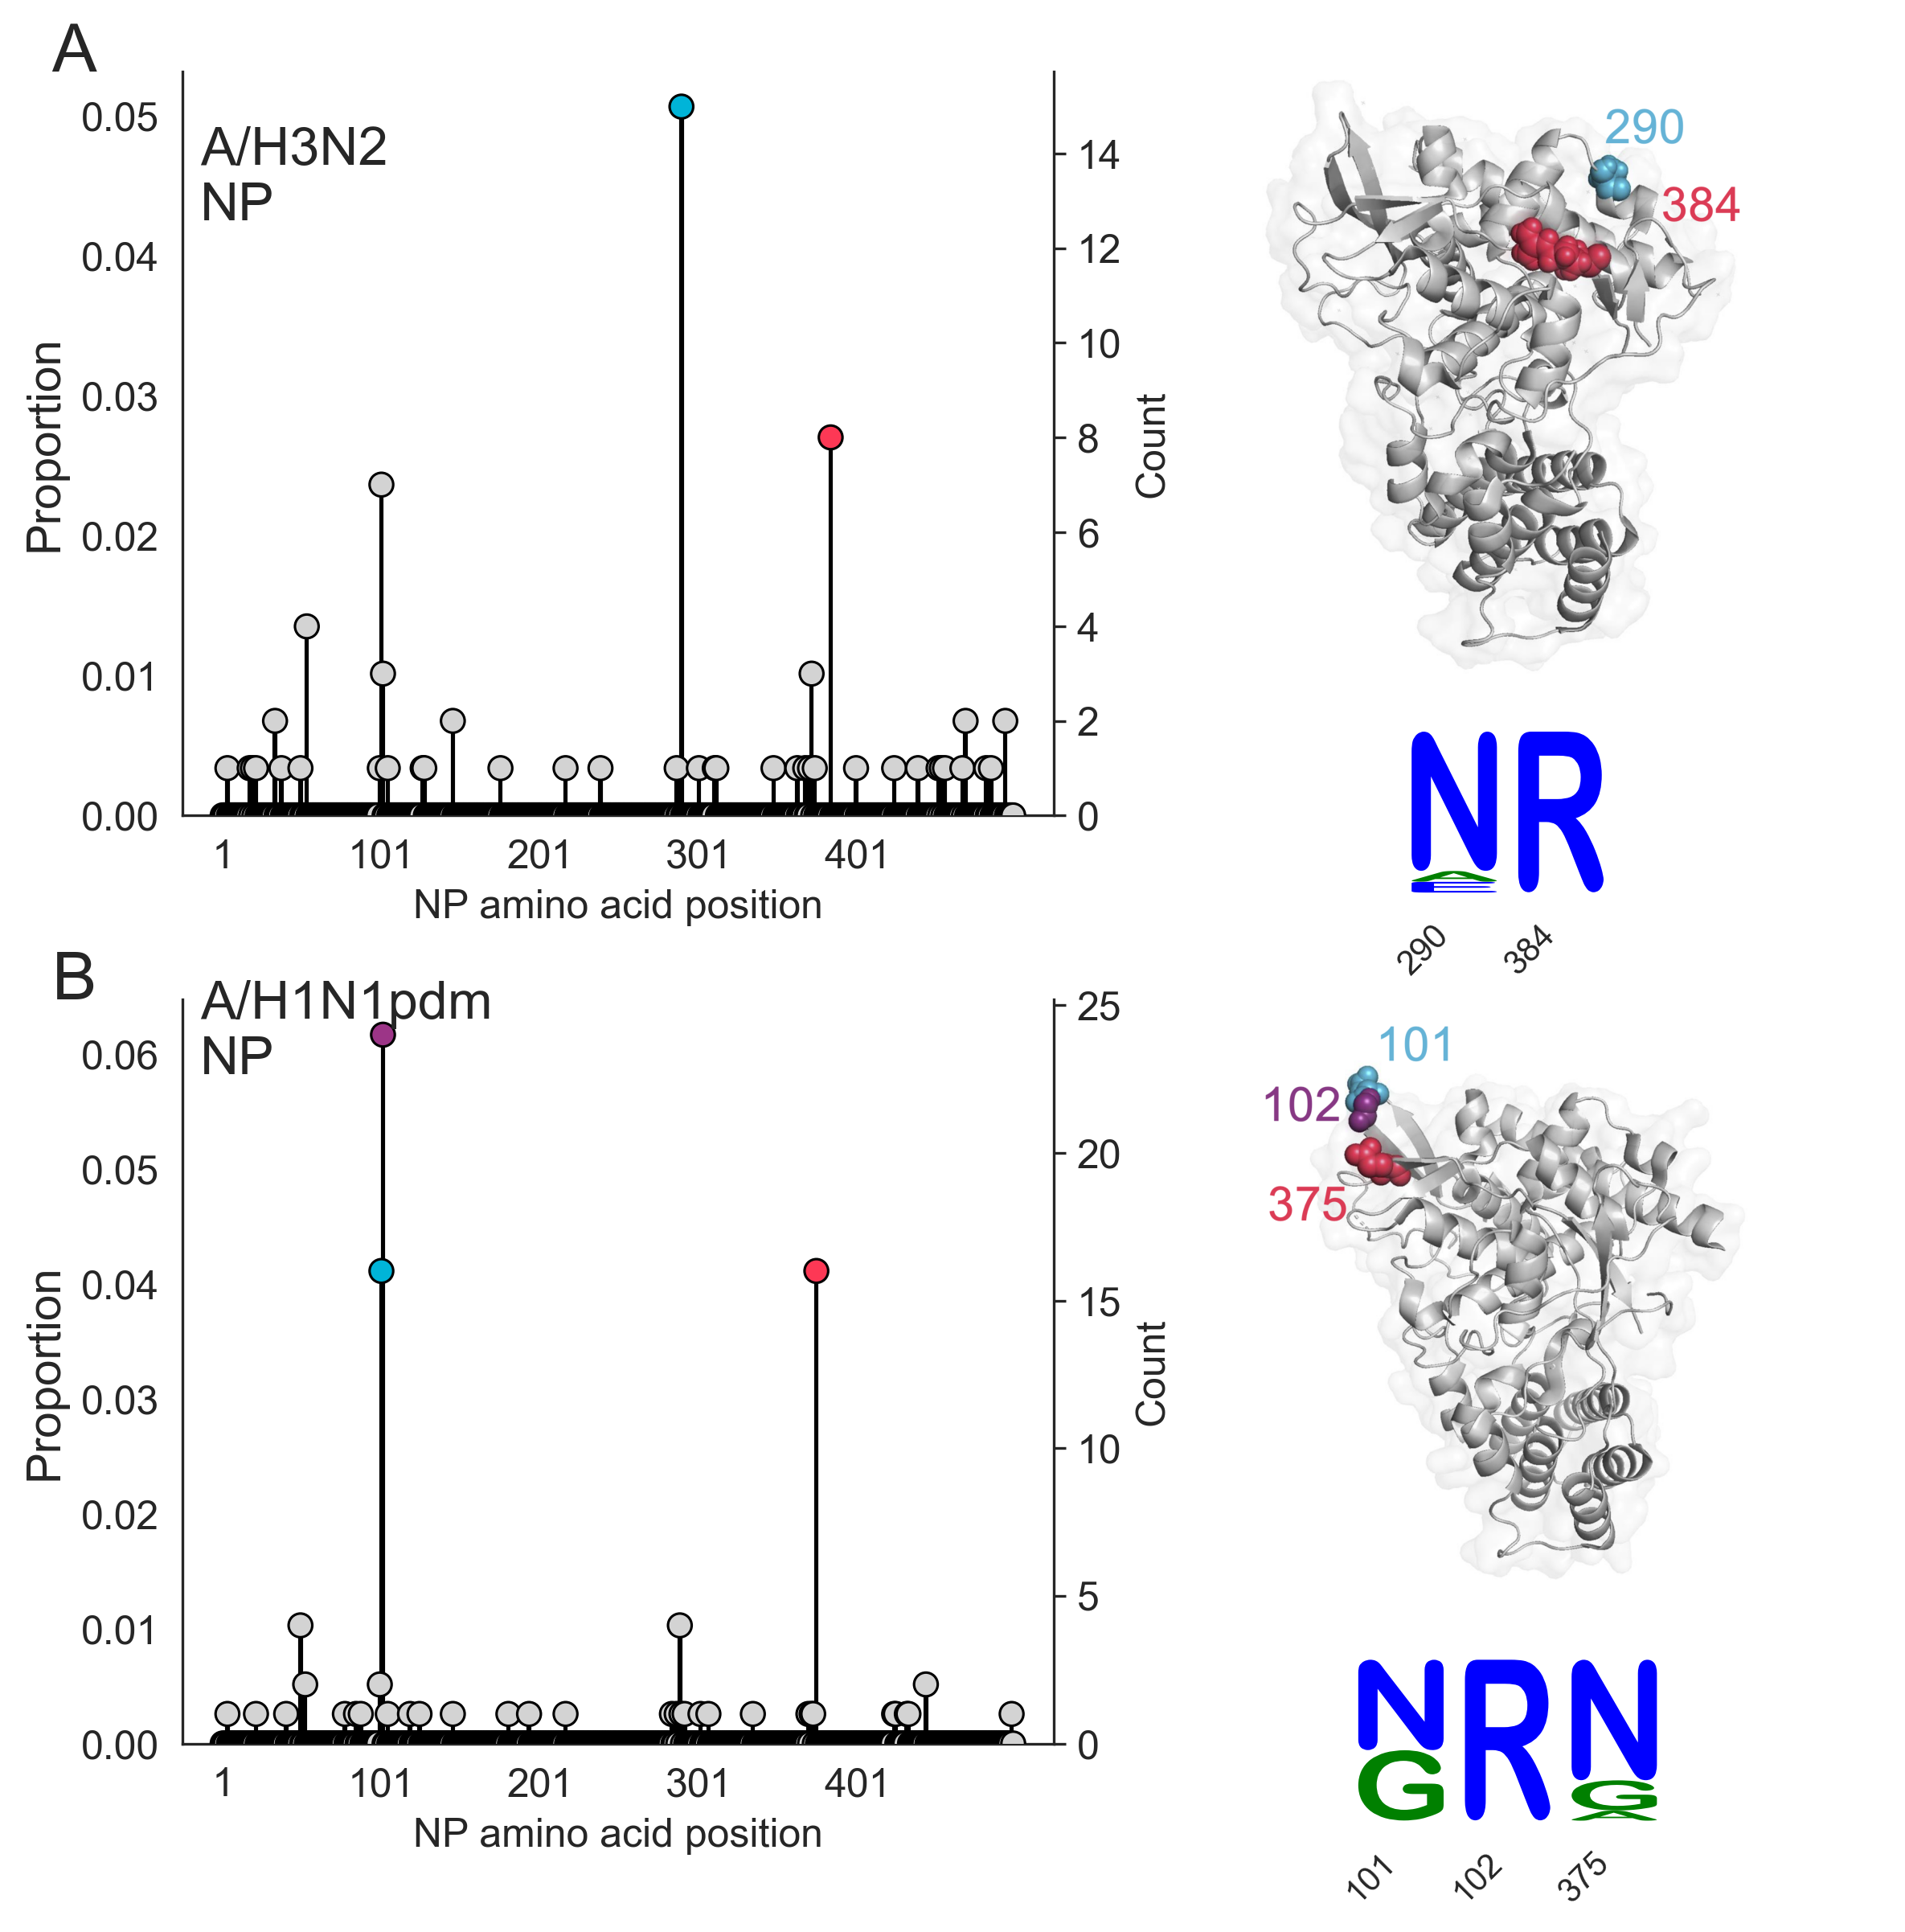

In [76]:
plot_np_supp(filename='Supplement-NP/SuppFig-NPadaptivemuts.png')